1. 데이터 준비와 확인  
2. 데이터로더 구성  
- 자신만의 data_loader 을 만들어 보자
- 데이터의 중복 제거
- NAN 결측치 제거
- 한국어 토크나이저 토큰화
- 불용어 제거
-사전 word_to_index 구성
-텍스트 스트링을 사전 인덱스 스트링으로 변환
-X_train, y_train, X_test, y_test, word_to_index 리턴
3. 모델 구성을 위한 데이터 분석 및 가공  
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
4. 모델 구성 및  validaiton set  구성
5. 모델 훈련 개시
6. Loss, Accuracy 그래프 시각화
7. 학습된 Embedding 레이어 분석  
8 한국어 Word2Vec 임베딩 활용하여 성능 개선

## 1. 데이터 준비와 확인

In [20]:
import pandas as pd
import tensorflow as tf
import numpy as np
import os

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()
# 부정 label 0 / 긍정 label 1

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 2. 데이터로더

In [21]:

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
       
        
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

In [22]:
index_to_word = {index:word for word, index in word_to_index.items()}
word_to_index={word:index for index, word in index_to_word.items()}
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

In [23]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다.
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장길이 분포
- 적절한 최대 문장 길이 지정(내가 지정)
-keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [24]:
print(len(X_train))
print(len(X_test))



146182
49157


In [25]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [26]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델 구성 및 validaiton set 구성

In [27]:
# validation set 60000건 분리
X_val = X_train[:49157]   
y_val = y_train[:49157]

# validation set을 제외한 나머지 train data
partial_X_train = X_train[49157:]
partial_y_train = y_train[49157:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(97025, 41)
(97025,)


In [28]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_RNN.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model_RNN.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


## 5. 모델학습

In [29]:
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history= model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)



Epoch 1/10
190/190 [==============================] - 3s 10ms/step - loss: 0.4584 - accuracy: 0.7959 - val_loss: 0.3583 - val_accuracy: 0.8460
Epoch 2/10
190/190 [==============================] - 1s 7ms/step - loss: 0.3256 - accuracy: 0.8641 - val_loss: 0.3404 - val_accuracy: 0.8516
Epoch 3/10
190/190 [==============================] - 1s 7ms/step - loss: 0.2911 - accuracy: 0.8791 - val_loss: 0.3431 - val_accuracy: 0.8512
Epoch 4/10
190/190 [==============================] - 1s 7ms/step - loss: 0.2641 - accuracy: 0.8931 - val_loss: 0.3434 - val_accuracy: 0.8537
Epoch 5/10
190/190 [==============================] - 1s 7ms/step - loss: 0.2393 - accuracy: 0.9043 - val_loss: 0.3562 - val_accuracy: 0.8527
Epoch 6/10
190/190 [==============================] - 1s 7ms/step - loss: 0.2160 - accuracy: 0.9150 - val_loss: 0.3770 - val_accuracy: 0.8506
Epoch 7/10
190/190 [==============================] - 1s 7ms/step - loss: 0.1969 - accuracy: 0.9234 - val_loss: 0.3878 - val_accuracy: 0.8496
Epoch

In [30]:
# 평가
results = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4607 - accuracy: 0.8389
[0.46071189641952515, 0.8389446139335632]


## 그래프

In [31]:
history_dict_RNN = history.history
print(history_dict_RNN.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


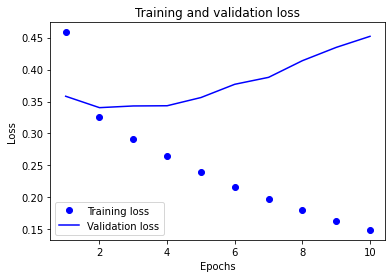

In [32]:
import matplotlib.pyplot as plt

acc = history_dict_RNN['accuracy']
val_acc = history_dict_RNN['val_accuracy']
loss = history_dict_RNN['loss']
val_loss = history_dict_RNN['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

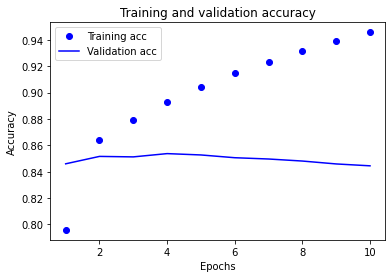

In [33]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 8. 한국어 word2Vec 임베딩을 활용하여 성능 개선

In [34]:
embedding_layer = model_RNN.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 200)


In [35]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model_RNN.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [36]:
!pip install gensim
!pip install --upgrade gensim==3.8.3

In [37]:
import gensim
gensim.__version__

'3.8.3'

In [39]:
from gensim.models import KeyedVectors

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec['사랑']
vector

/tmp/ipykernel_2951/1305251480.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec['사랑']


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [40]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_2951/1730871920.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_2951/1730871920.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [41]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 200  # 워드 벡터의 차원 수 

# 모델 구성
model_RNN = tf.keras.Sequential()
model_RNN.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning


model_RNN.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_RNN.add(tf.keras.layers.Dense(8, activation='relu'))
model_RNN.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_RNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 8)                 6688      
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [42]:
# 학습의 진행
model_RNN.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5 # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model_RNN.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
190/190 [==============================] - 4s 15ms/step - loss: 0.5860 - accuracy: 0.7021 - val_loss: 0.4532 - val_accuracy: 0.8074
Epoch 2/5
190/190 [==============================] - 2s 12ms/step - loss: 0.3989 - accuracy: 0.8301 - val_loss: 0.3742 - val_accuracy: 0.8397
Epoch 3/5
190/190 [==============================] - 2s 12ms/step - loss: 0.3389 - accuracy: 0.8583 - val_loss: 0.3563 - val_accuracy: 0.8469
Epoch 4/5
190/190 [==============================] - 2s 12ms/step - loss: 0.3086 - accuracy: 0.8726 - val_loss: 0.3533 - val_accuracy: 0.8488
Epoch 5/5
190/190 [==============================] - 2s 11ms/step - loss: 0.2901 - accuracy: 0.8820 - val_loss: 0.3546 - val_accuracy: 0.8496


In [43]:
# 테스트셋을 통한 모델 평가
results = model_RNN.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.3673 - accuracy: 0.8425
[0.3673251271247864, 0.842504620552063]


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


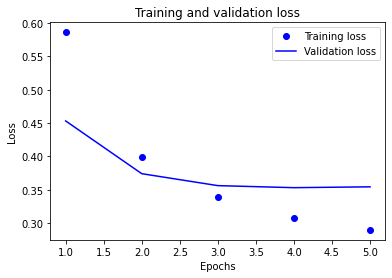

In [44]:
history_dict_RNN =history.history
print(history_dict_RNN.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

import matplotlib.pyplot as plt

acc = history_dict_RNN['accuracy']
val_acc = history_dict_RNN['val_accuracy']
loss = history_dict_RNN['loss']
val_loss = history_dict_RNN['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

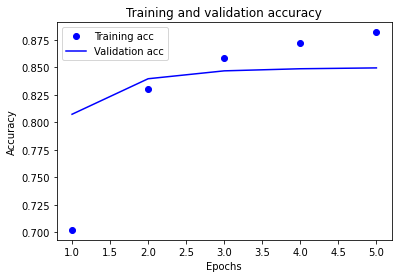

In [45]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 회기
- 이번 프로젝트에서 **어려웠던 점**:  이번 프로젝트는 어렵기 보다 재미있게 느껴졌다.
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**:  꼭 터미널에서 설치하는게 아니라 cell 에서도 ! 를 사용하면 바로 설치를 할 수 있다는점, 또 프로그램 다운그레이드 방법 !pip install --upgrade gensim==3.8.3 알았다. 모호한부분은 word2vec 를 사용해서 학습량을 늘린 layer 을 사용했지만 효과에 대한 부분이 모호하다.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들** : RNN 모델경우 word2vec 전 정확도가 83% 후 정확도가 84.25%, CNN1개 경우 word2vec 전 정확도가 84.55% 후 정확도가 82.15% , CNN2개 경우 word2vec 전 정확도가 82% 후 정확도가 82.15% 로 별로 변화가 없었다. exploration 설명을 보면 보통 word2vec layer 을 임베디드 레이어로 사용하게 되면 평균 5% 정확도가 올라간다고 했지만 나는 조금 오르거나, 유지하거나, 오히려 떨어지는 경우도 있었다. 그래서 epoch 에 따른 정확도 변화를 보았지만 epoch 3 까지는 오르다가 더이상 내려가지도 오르지도 않고 임게점에서 유지하는 그래프 현상을 보였다. 그래서 추가한 layer가 효과가 있는지 의문이 들었다.    
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**:  많은걸 시도해봤지만 이번 프로젝트의 경우 정말 모르겠다.
- **자기 다짐** : RNN 모델에 대해서 더 잘 알게되었고 혼자공부하는 머신러닝, 딥러닝을 공부를 더 열심히 해서 코드 한줄 한줄 무엇을 의미하는지 알고싶고 더 공부를 열심히 해야겠다.